In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from plotnine import *


# ADDRESS

In [3]:
meta_smile = pd.read_csv('meta_eGeMAPSv01b.csv')
meta_smile.head()

,Unnamed: 0,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
0,0,0,S001,74,male,30,cc,train,26.871142,cc
1,1,1,S002,62,female,30,cc,train,26.556385,cc
2,2,2,S003,69,female,29,cc,train,25.519604,cc
3,3,3,S004,71,female,30,cc,train,27.771522,cc
4,4,4,S005,74,female,30,cc,train,26.533502,cc


In [4]:
print(np.sqrt(mean_squared_error(meta_smile['MMSE'], meta_smile['predict'] )))

4.8916933197580414


In [5]:
meta_lstm = pd.read_csv('4-RollingWindow+LSTM+WN.csv')
meta_lstm.head()

,Unnamed: 0,index,ID,Age,Gender,MMSE,Group,split,predict,predict_group
0,0,0,S001,74,male,30,cc,train,26.442938,cc
1,1,1,S002,62,female,30,cc,train,26.371628,cc
2,2,2,S003,69,female,29,cc,train,23.839193,cd
3,3,3,S004,71,female,30,cc,train,26.750227,cc
4,4,4,S005,74,female,30,cc,train,23.580471,cd


In [6]:
print(np.sqrt(mean_squared_error(meta_lstm['MMSE'], meta_lstm['predict'] )))

6.008748657564505


In [7]:
meta_bert = pd.read_csv('meta_bert.csv')
meta_bert['ID'] = [x +' ' for x in meta_bert['ID']]
meta_bert.head()

,Unnamed: 0,Unnamed: 0.1,ID,Age,Gender,TEXT,MMSE,Group,predict,split
0,0,0,S001,74,male,well there's a mother standing there washing ...,30,cc,26.000910,train
1,1,1,S002,62,female,somebody's getting cookies out_of the cookie ...,30,cc,28.357574,train
2,2,2,S003,69,female,okay . there's a little boy and he's standing...,29,cc,25.372913,train
3,3,3,S004,71,female,are you ready ? well the sink is overflowing ...,30,cc,23.448502,train
4,4,4,S005,74,female,okay . the mother's washing the dishes and th...,30,cc,26.735813,train


In [8]:
meta_ensemble = pd.merge(meta_smile[['ID', 'Group', 'split', 'MMSE', 'predict']], 
                         meta_lstm[['ID', 'Group', 'predict']],
                         on = ['ID', 'Group'], 
                         suffixes = ('_smile', '_lstm'))
meta_ensemble = pd.merge(meta_ensemble, meta_bert[['ID', 'Group', 'predict']], 
                         on = ['ID', 'Group']).rename(columns = {'predict':'predict_bert'})
meta_ensemble.head()

,ID,Group,split,MMSE,predict_smile,predict_lstm,predict_bert
0,S001,cc,train,30,26.871142,26.442938,26.000910
1,S002,cc,train,30,26.556385,26.371628,28.357574
2,S003,cc,train,29,25.519604,23.839193,25.372913
3,S004,cc,train,30,27.771522,26.750227,23.448502
4,S005,cc,train,30,26.533502,23.580471,26.735813


In [9]:
meta_ensemble['predict_ensemble'] = (meta_ensemble['predict_smile'] + meta_ensemble['predict_lstm'] + meta_ensemble['predict_bert'])/3
meta_ensemble['predict_ensemble'].describe()

count    108.000000
mean      22.952867
std        2.545958
min       12.541381
25%       21.256496
50%       23.423757
75%       24.906208
max       27.095196
Name: predict_ensemble, dtype: float64

In [10]:
x_train = meta_ensemble[['predict_smile', 'predict_lstm', 'predict_bert']][meta_ensemble.split == 'train']
y_train = meta_ensemble['MMSE'][meta_ensemble.split == 'train']

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ensemble = LinearRegression().fit(x_train, y_train)

In [12]:
ensemble.coef_

array([0.73355524, 0.83210089, 0.64137323])

In [13]:
ensemble.intercept_

-27.583193295456663

In [14]:
meta_ensemble['predict_ensemble_lm'] = ensemble.predict(meta_ensemble[['predict_smile', 'predict_lstm', 'predict_bert']])
meta_ensemble['predict_ensemble_lm'] = meta_ensemble['predict_ensemble_lm'].clip(0, 30)

In [15]:
meta_ensemble.describe()

,MMSE,predict_smile,predict_lstm,predict_bert,predict_ensemble,predict_ensemble_lm
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,23.092593,22.046586,23.283673,23.528343,22.952867,22.986834
std,7.215685,4.594513,2.841247,2.050655,2.545958,5.557440
min,1.000000,1.000000,14.805541,17.625240,12.541381,0.000000
25%,17.000000,18.844074,21.718843,22.291021,21.256496,19.215432
50%,27.000000,22.626012,23.705966,23.149605,23.423757,24.222455
75%,29.000000,25.834717,25.465997,24.646701,24.906208,27.256996
max,30.000000,28.871155,27.102104,29.074232,27.095196,30.000000


In [16]:
meta_ensemble

,ID,Group,split,MMSE,predict_smile,predict_lstm,predict_bert,predict_ensemble,predict_ensemble_lm
0,S001,cc,train,30,26.871142,26.442938,26.000910,26.438330,30.000000
1,S002,cc,train,30,26.556385,26.371628,28.357574,27.095196,30.000000
2,S003,cc,train,29,25.519604,23.839193,25.372913,24.910570,27.246968
3,S004,cc,train,30,27.771522,26.750227,23.448502,25.990084,30.000000
4,S005,cc,train,30,26.533502,23.580471,26.735813,25.616596,28.649562
...,...,...,...,...,...,...,...,...,...
103,S150,cd,train,20,22.538189,26.785460,23.104223,24.142624,26.056449
104,S151,cd,train,24,19.781225,23.891418,23.634209,22.435617,21.965848
105,S153,cd,train,12,14.708446,19.908094,21.155466,18.590669,13.340357
106,S154,cd,train,20,26.909793,19.222261,24.318151,23.483402,23.748499


In [20]:
meta_ensemble[meta_ensemble.ID == 'S090 ']

,ID,Group,split,MMSE,predict_smile,predict_lstm,predict_bert,predict_ensemble,predict_ensemble_lm
63,S090,cd,train,8,11.129374,16.806601,17.62524,15.187072,5.869962


In [43]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse_smile = np.sqrt(mean_squared_error(g['MMSE'], g['predict_smile']))
    rmse_lstm = np.sqrt(mean_squared_error(g['MMSE'], g['predict_lstm']))
    rmse_bert = np.sqrt(mean_squared_error(g['MMSE'], g['predict_bert']))

    rmse_ensemble = np.sqrt(mean_squared_error(g['MMSE'], g['predict_ensemble']))
    rmse_ensemble_lm = np.sqrt(mean_squared_error(g['MMSE'], g['predict_ensemble_lm']))

    return pd.Series(dict(rmse_smile = rmse_smile, 
                          rmse_lstm = rmse_lstm,
                          rmse_bert = rmse_bert,
                          rmse_ensemble = rmse_ensemble, 
                          rmse_ensemble_lm = rmse_ensemble_lm))

meta_ensemble.groupby('split').apply(cal_rmse).reset_index()

,split,rmse_smile,rmse_lstm,rmse_bert,rmse_ensemble,rmse_ensemble_lm
0,test,4.438016,6.238737,6.496253,5.407021,3.352249
1,train,5.331180,5.788025,5.970755,5.288638,4.424708
2,val,2.714005,6.731839,7.900499,5.517454,3.758295


In [44]:
cal_rmse(meta_ensemble)

rmse_smile          4.891693
rmse_lstm           6.008749
rmse_bert           6.375483
rmse_ensemble       5.341845
rmse_ensemble_lm    4.178193
dtype: float64

In [49]:
meta_ensemble['split'] = meta_ensemble['split'].astype('category').cat.reorder_categories(['train', 'test', 'val'])

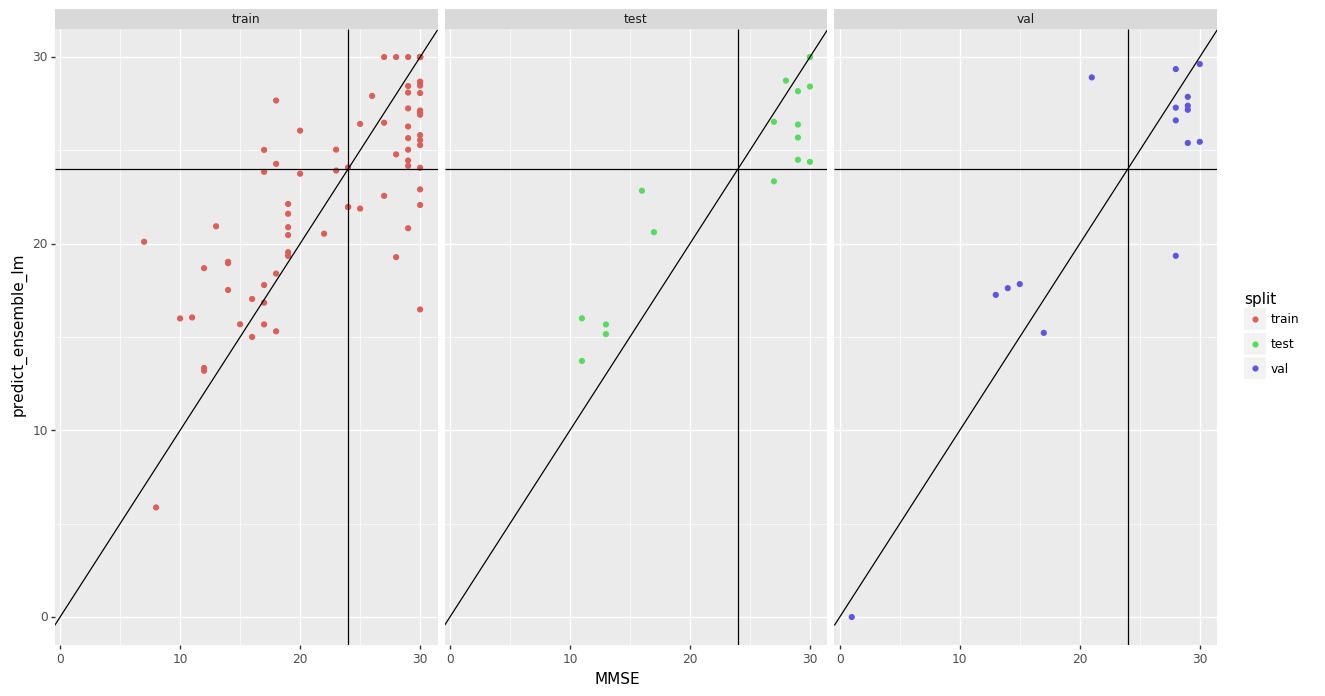

<ggplot: (-9223363265101268108)>

In [50]:
ggplot(meta_ensemble) + \
geom_point(aes(x = 'MMSE', y = 'predict_ensemble_lm', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

In [46]:
meta_ensemble['predict_ensemble_group'] = ['cc' if x >= 24 else 'cd' for x in meta_ensemble.predict_ensemble_lm]
y_true = meta_ensemble.Group
y_pred = meta_ensemble.predict_ensemble_group
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.82      0.87      0.85        54
          cd       0.86      0.81      0.84        54

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.84      0.84      0.84       108



# Pitt Corpus

In [29]:
meta_pitt_smile = pd.read_csv('meta_pitt_eGeMAPSv01b.csv')
meta_pitt_smile.head()

,Unnamed: 0,file,ID,Group,MMSE,predict,predict_group
0,0,/tf/data/dementia/English/Pitt/Control/cookie/...,255-1,Control,28.0,17.759423,Dementia
1,0,/tf/data/dementia/English/Pitt/Control/cookie/...,056-3,Control,29.0,25.626785,Control
2,0,/tf/data/dementia/English/Pitt/Control/cookie/...,139-3,Control,30.0,15.066687,Dementia
3,0,/tf/data/dementia/English/Pitt/Control/cookie/...,210-2,Control,29.0,25.299405,Control
4,0,/tf/data/dementia/English/Pitt/Control/cookie/...,109-1,Control,30.0,26.835056,Control


In [30]:
meta_pitt_smile = meta_pitt_smile[meta_pitt_smile['MMSE'].notnull()]

print(np.sqrt(mean_squared_error(meta_pitt_smile['MMSE'], meta_pitt_smile['predict'] )))

7.944049228497729


In [26]:
meta_pitt_lstm = pd.read_csv('4-RollingWindow+LSTM+WN-pitt.csv')
meta_pitt_lstm.head()
meta_pitt_lstm = meta_pitt_lstm[meta_pitt_lstm['MMSE'].notnull()]

print(np.sqrt(mean_squared_error(meta_pitt_lstm['MMSE'], meta_pitt_lstm['predict'] )))

6.2860519836257875


In [31]:
meta_pitt_ensemble = pd.merge(meta_pitt_smile[['ID', 'Group', 'MMSE', 'predict']], 
                              meta_pitt_lstm[['ID', 'Group', 'predict']], 
                              on = ['ID', 'Group'], 
                              suffixes = ('_smile', '_lstm'))
meta_pitt_ensemble.head()

,ID,Group,MMSE,predict_smile,predict_lstm
0,255-1,Control,28.0,17.759423,26.444284
1,056-3,Control,29.0,25.626785,25.113256
2,139-3,Control,30.0,15.066687,23.186214
3,210-2,Control,29.0,25.299405,26.462302
4,109-1,Control,30.0,26.835056,24.406082


In [34]:
meta_pitt_ensemble['predict_ensemble'] = .5 * meta_pitt_ensemble['predict_smile'] + .5 * meta_pitt_ensemble['predict_lstm']
meta_pitt_ensemble['predict_ensemble'].describe()


count    457.000000
mean      23.009577
std        2.873090
min       12.741621
25%       21.095128
50%       23.180491
75%       25.178343
max       28.397079
Name: predict_ensemble, dtype: float64

In [36]:
print(np.sqrt(mean_squared_error(meta_pitt_ensemble['MMSE'], meta_pitt_ensemble['predict_ensemble'] )))

6.57998360609221
